In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import  roc_curve, auc, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from imblearn.over_sampling import RandomOverSampler

In [2]:
# Load pre-processed data
SG_CRC_GE = pd.read_csv("SingaporeCRC_data/SG_CRC_GE.csv", index_col=0, delimiter=",")
SG_CRC_GE

C:\Users\Zhongyuan\AppData\Local\Temp\ipykernel_1708\3720810233.py:2: DtypeWarning: Columns (39667) have mixed types. Specify dtype option on import or set low_memory=False.
  SG_CRC_GE = pd.read_csv("SingaporeCRC_data/SG_CRC_GE.csv", index_col=0, delimiter=",")


,TSPAN6,TNMD,DPM1,SCYL3,FIRRM,FGR,CFH,FUCA2,GCLC,NFYA,...,Age.at.Diagnosis,Site.of.Primary.Colorectal.tumour,Side,Grade,TNM,Stage,iCMS,CMS,group3,group5
patient_id1,,,,,,,,,,,,,,,,,,,,,
1504.0,21.899490,0.201798,24.813475,2.385601,2.423479,1.719561,4.938426,17.340649,17.525062,8.360323,...,70.0,Rectum,Left,2,T2N1(3/21)M1,IV,iCMS2,CMS4,iCMS2_MSS,iCMS2_fibrotic
1603.0,23.051914,0.336181,32.488898,3.491298,4.838602,1.709233,5.097042,23.091196,25.009775,16.164803,...,66.0,Rectosigmoid junction,Left,2,T3N0(0/19)M0,IIA,iCMS2,CMS2,iCMS2_MSS,iCMS2_MSS
1324.0,17.759606,0.321224,73.592613,3.189865,4.491900,0.835416,2.342624,26.887325,30.539995,13.148909,...,73.0,Sigmoid colon,Left,2,T3N1c(0/17)M0,IIIB,iCMS2,CMS2,iCMS2_MSS,iCMS2_MSS
834.0,10.718835,0.092844,22.659393,2.741735,3.737818,0.692069,1.440818,10.085834,14.951673,7.726470,...,71.0,Rectosigmoid junction,Left,2,T3N0(0/27)M0,IIA,iCMS2,CMS2,iCMS2_MSS,iCMS2_MSS
1662.0,27.208802,0.745929,14.048898,5.442878,1.954963,2.571285,7.385909,15.042006,14.375950,6.126601,...,67.0,Rectum,Left,2,T3N1a(1/36)M0,IIIB,iCMS3,CMS3,iCMS3_MSS,iCMS3_MSS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1607.0,23.451535,0.108787,17.911861,3.298083,4.157520,0.483072,1.646369,19.915323,25.855965,7.355974,...,67.0,Ascending colon,Right,2,T3N1b(2/32)M0,IIIB,iCMS3,CMS3,iCMS3_MSS,iCMS3_MSS
1448.0,22.468734,0.633003,23.361645,4.886279,5.240244,0.450576,1.690369,15.562312,19.087965,9.101713,...,68.0,Rectum,Left,2,T3N2(4/17)M0,IIIB,iCMS2,CMS2,iCMS2_MSS,iCMS2_MSS
891.0,5.567352,0.110154,10.611309,7.648380,4.337681,5.249050,6.239189,15.364255,18.859650,6.947568,...,73.0,Splenic flexure,Left,2,T3N1(1/19)M0,IIA,iCMS3,CMS4,iCMS3_MSS,iCMS3_fibrotic


In [3]:
class_counts = SG_CRC_GE['iCMS'].value_counts()
print(class_counts)

iCMS
iCMS2    62
iCMS3    51
Name: count, dtype: int64


In [4]:
# Prepare features and target variable
X = SG_CRC_GE.drop(['TMB', 'KRAS_y', 'BRAF_y', 'NRAS_y', 'TP53_y',
       'APC_y', 'PIK3CA_y', 'PIK3R1_y', 'SMAD4_y', 'ERBB4_y', 'RNF43_y',
       'ZNRF3_y', 'KIT_y', 'TGFBR2_y', 'Vital.status', 'MSI.Status', 'CRIS',
       'Gender', 'Age.at.Diagnosis', 'Site.of.Primary.Colorectal.tumour',
       'Side', 'Grade', 'TNM', 'Stage', 'iCMS', 'CMS', 'group3', 'group5'], axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y = SG_CRC_GE['iCMS']
print("Unique values of y:", np.unique(y))
le = LabelEncoder()
y = le.fit_transform(y)
y
print("Unique values of y:", np.unique(y))
print("Shape of y:", X_scaled.shape)
print("Shape of y:", y.shape)

Unique values of y: ['iCMS2' 'iCMS3']
Unique values of y: [0 1]
Shape of y: (113, 39645)
Shape of y: (113,)


In [5]:
# Oversampling to ensure class balance
from imblearn.over_sampling import SMOTE
#oversampler = RandomOverSampler(sampling_strategy='minority', random_state=42)
#X_scaled, y = oversampler.fit_resample(X_scaled,y)

sm = SMOTE(sampling_strategy='not majority', k_neighbors= 5, random_state=42)
X_scaled, y = sm.fit_resample(X_scaled, y)

print(X_scaled.shape)
print(y.shape)

(124, 39645)
(124,)


In [6]:
# Feature selection
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC

random_seed = 42
lsvc = LinearSVC(C = 0.1, penalty="l1", dual=False).fit(X_scaled, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X_scaled)

X_new.shape

(124, 54)

Best Parameters: {'alpha': 0.01, 'eta': 0.01, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 20}
Best Score: 0.9549019607843137
Test Set Accuracy: 0.9736842105263158


<Figure size 800x600 with 0 Axes>

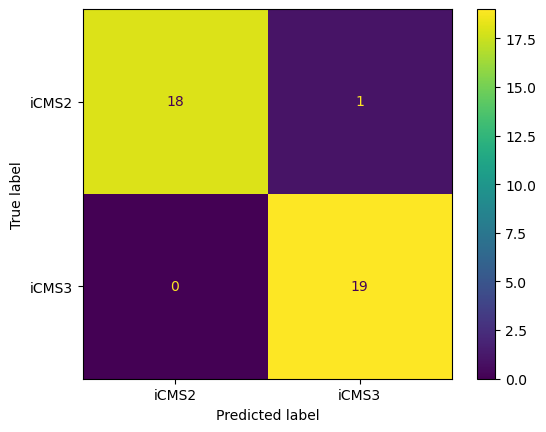

              precision    recall  f1-score   support

       iCMS2       1.00      0.95      0.97        19
       iCMS3       0.95      1.00      0.97        19

    accuracy                           0.97        38
   macro avg       0.97      0.97      0.97        38
weighted avg       0.97      0.97      0.97        38



In [7]:
# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, shuffle=True, random_state=42, stratify=y)

# Define parameters for XGBoost model
params = {
    'learning_rate':[0.01, 0.1],
    'max_depth': [3, 6, 9],
    'eta': [0.01, 0.1],
    #'lambda': [0.1, 1]
    'alpha': [0.01, 0.1], # Include L1 regularization
    'n_estimators': [20, 50, 100]
}

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', seed=42)

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=params, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Evaluate on test set
test_score = grid_search.best_estimator_.score(X_test, y_test)
print("Test Set Accuracy:", test_score)

y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['iCMS2', 'iCMS3'])
plt.figure(figsize=(8, 6)) 
cm_display.plot()
plt.show()

# Calculate precision, recall, and F1-score
report = classification_report(y_test, y_pred, target_names=['iCMS2', 'iCMS3'])
print(report)

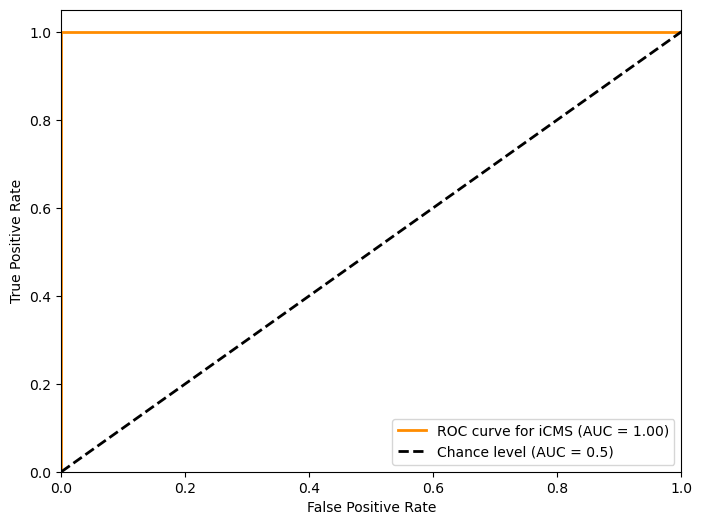

In [8]:
# Predict probabilities
y_prob = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plotting the AUROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve for iCMS (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, label=f'Chance level (AUC = 0.5)', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

C:\Users\Zhongyuan\AppData\Local\Temp\ipykernel_1708\951501840.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances[top_20_indices], y=feature_names[top_20_indices], palette="viridis")


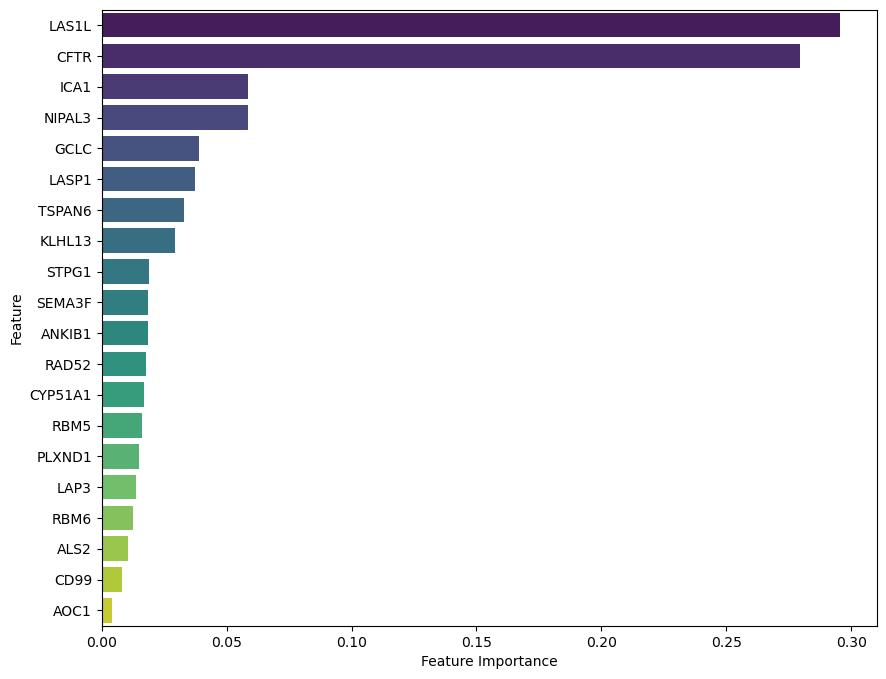

In [9]:
# Train XGBoost model with best parameters
best_xgb_model = xgb.XGBClassifier(objective='binary:logistic',eval_metric='logloss', **best_params)
best_xgb_model.fit(X_train, y_train)

feature_importances = best_xgb_model.feature_importances_
top_20_indices = feature_importances.argsort()[::-1][:20]
feature_names = X.columns

plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances[top_20_indices], y=feature_names[top_20_indices], palette="viridis")
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

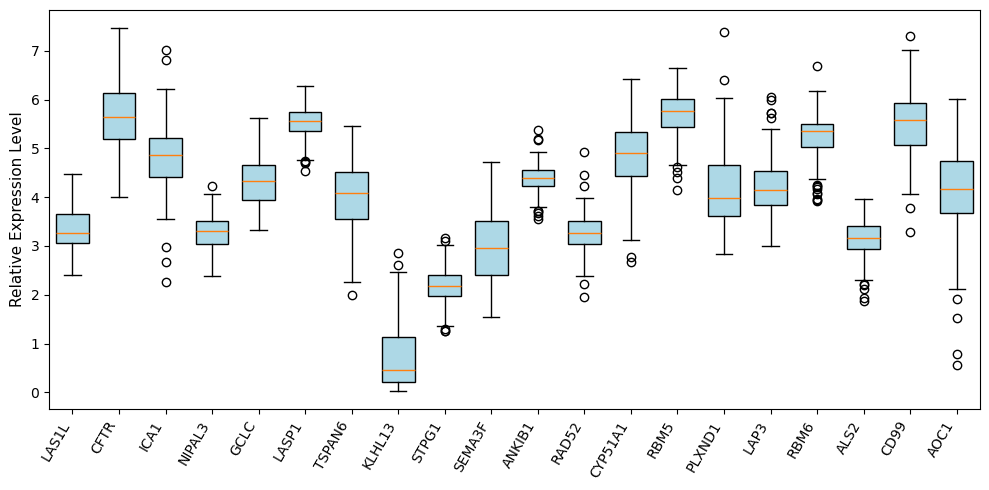

In [10]:
# Box plot for visualizing relative gene expression of 20 most important genes
data = {}
top_20_feature_names = feature_names[top_20_indices]
abundance_scaled = np.log2(X+1)

for column_name in top_20_feature_names:
    data[column_name] = abundance_scaled[column_name]

plt.figure(figsize=(10, 5))
plt.boxplot(data.values(), widths=0.7, patch_artist=True, 
            boxprops=dict(facecolor='lightblue'), whiskerprops=dict(color='black'))

#plt.ylim(-0.5, 8)
plt.ylabel('Relative Expression Level', fontsize=11)
plt.xticks(range(1, len(data) + 1), data.keys(), rotation=60, ha='right', fontsize=10)
plt.tight_layout()
plt.show()